# AWS Comprehend Sentiment Analysis Using Python

This notebook shows how to use boto3 Amazon API to use Amazon Comprehend for real time analysis as well as scheduling analysis jobs.
1. For boto3 to work you need to create an IAM User, receive `aws_access_key_id` and `aws_secret_access_key` and configure your credentials using AWS Command Line Interface (AWS CLI)
2. Cost. If you are using free AWS tier, you can analyze 50K units a month free.  Every unit is 100 characters. In my example, every tweet is ~2 units. In the scheduled job I am analyzing 10K tweets at once, so the free tier runs out pretty fast, and then it's \$1 per 10K. Be sure to check pricing before you proceed. https://aws.amazon.com/comprehend/pricing/
3. Reference. Boto3 S3: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/comprehend.html  Boto3 Comprehend: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html

In [1]:
pip install boto3 langdetect textblob

     |████████████████████████████████| 131 kB 8.5 MB/s 
     |████████████████████████████████| 981 kB 44.4 MB/s 
     |████████████████████████████████| 8.4 MB 45.1 MB/s 
     |████████████████████████████████| 79 kB 6.3 MB/s 
     |████████████████████████████████| 138 kB 35.5 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=baafcda3dc40928998f45b0a4463de0e39d0f99ad2b9d9716f2ba35974babc7f
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urll

In [2]:
!pip install emoji --upgrade

     |████████████████████████████████| 170 kB 7.5 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=60341b5a0b486dab811401f5de0970702aff894c37ef4d0a7d0fbf3c7a9345cf
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [109]:
import configparser
import os

from langdetect import detect

import boto3

import pandas as pd
import json
import tarfile  # for unzipping files

from emoji import demojize

from platform import python_version

In [110]:
print(python_version())

3.7.12


In [111]:
pd.set_option('display.max_colwidth', None)

In [ ]:
# https://github.com/chonchonj23/Scrapped_Comments_YouTube_Covid/blob/master/YouTube_comments.xlsx

# df_excel = pd.read_excel('YouTube_comments.xlsx', index_col=0)  

## Data extracted from Youtube API

In [112]:
# Comments extracted from Youtube videos via Youtube API 
# link_to_data = "https://raw.githubusercontent.com/chonchonj23/Comments-data-from-Youtube-videos-related-to-COVID-19/main/Youtube_Comments_Combined_16Dec.csv"

link_to_data = "https://raw.githubusercontent.com/chonchonj23/COVID-comments-in-Youtube/master/Youtube_COVID_Comments_16Dec_All_v2.csv"

df_csv = pd.read_csv(link_to_data, header = 0, dtype = 'str', encoding = 'utf-8', lineterminator='\n') 

In [113]:
df_csv.count()

Youtube Comments    355143
Video ID            355147
dtype: int64

In [114]:
df_csv.head()

,Youtube Comments,Video ID
0,"who cares, the next variant decepticon is the one to worry about",ih4xVzLQP24
1,Worldwide...except for Africa.,ih4xVzLQP24
2,"Once one case is found, the genie :man_genie: is out of the bottle, spreading like a wild fire. USA should get ready to give boosters nor when Mr micron comes, and spreads people are ready.",ih4xVzLQP24
3,Imagine believing this bs,ih4xVzLQP24
4,"Europe admits Omicron was found IN EUROPE BEFORE AFRICA. So why was South Africa blamed for sounding the alarm?\r;Europe admits Covid19 was found IN EUROPE BEFORE CHINA. So why was China blamed for sounding the alarm?\r;Covid deaths = Managed pandemic China 4,636 & New Zealand 48 Mismanaged pandemic US 823,390.\r;Covid originated at Fort Detrick, Maryland and Spanish flu in Haskell County, Kansas. SO WHY DID AMERICA NOT SOUND THE ALARM ?",ih4xVzLQP24


In [115]:
df_k = df_csv[df_csv['Youtube Comments'].notnull()]
# df = df_k.rename({'Comments': 'Youtube Comments'}, axis=1)
df = df_k
df['Youtube Comments'] = df['Youtube Comments'].apply(lambda x: demojize(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [116]:
df.count()

Youtube Comments    355143
Video ID            355143
dtype: int64

In [ ]:
# df = df.reset_index()

In [16]:
df.head(5)

,Youtube Comments,Video ID
0,"who cares, the next variant decepticon is the one to worry about",ih4xVzLQP24
1,Worldwide...except for Africa.,ih4xVzLQP24
2,"Once one case is found, the genie :man_genie: is out of the bottle, spreading like a wild fire. USA should get ready to give boosters nor when Mr micron comes, and spreads people are ready.",ih4xVzLQP24
3,Imagine believing this bs,ih4xVzLQP24
4,"Europe admits Omicron was found IN EUROPE BEFORE AFRICA. So why was South Africa blamed for sounding the alarm?\r;Europe admits Covid19 was found IN EUROPE BEFORE CHINA. So why was China blamed for sounding the alarm?\r;Covid deaths = Managed pandemic China 4,636 & New Zealand 48 Mismanaged pandemic US 823,390.\r;Covid originated at Fort Detrick, Maryland and Spanish flu in Haskell County, Kansas. SO WHY DID AMERICA NOT SOUND THE ALARM ?",ih4xVzLQP24


## Continued

In [117]:
df.count()

Youtube Comments    355143
Video ID            355143
dtype: int64

In [118]:
# to identify English Comments

def isEnglish(s):
  try:
      # s.isalpha()
      # return s.isalpha()
      s.isascii()
      return s.isascii()

  except Exception:
      return False

In [ ]:
# isEnglish("’")

In [ ]:
# isEnglish("I thought they were “vaccinated” when will y’all wake up. What’s the point of the vaccination if you’re just going to quarantine everyone")

In [119]:
df['Youtube Comments'] = df['Youtube Comments'].str.strip()

df['language'] = df['Youtube Comments'].replace("’", "", regex=True)\
.replace("1:1", "", regex=True).replace("…", "", regex=True).replace("”", "", regex=True)\
.replace("’", "", regex=True).replace("“", "", regex=True)\
.replace("\n", ";", regex=True).replace("\t", ";", regex=True).replace("\r", ";", regex=True).replace("\v", ";", regex=True)\
.replace("-", "", regex=True).replace("      ", "", regex=True)\
.apply(lambda x: isEnglish(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [120]:
# .replace("/n", ";", regex=True).replace("/t", ";", regex=True).replace("/r", ";", regex=True).replace("/v", ";", regex=True)\

df['Youtube Comments'] = df['Youtube Comments'].replace("’", "", regex=True)\
.replace("1:1", "", regex=True).replace("…", "", regex=True).replace("”", "", regex=True)\
.replace("’", "", regex=True).replace("“", "", regex=True)\
.replace("\n", ";", regex=True).replace("\t", ";", regex=True).replace("\r", ";", regex=True).replace("\v", ";", regex=True)\
.replace("-", "", regex=True).replace("      ", "", regex=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


'Sad stuff happening.'

In [21]:
df.head(5)

,Youtube Comments,Video ID,language
0,"who cares, the next variant decepticon is the one to worry about",ih4xVzLQP24,True
1,Worldwide...except for Africa.,ih4xVzLQP24,True
2,"Once one case is found, the genie :man_genie: is out of the bottle, spreading like a wild fire. USA should get ready to give boosters nor when Mr micron comes, and spreads people are ready.",ih4xVzLQP24,True
3,Imagine believing this bs,ih4xVzLQP24,True
4,"Europe admits Omicron was found IN EUROPE BEFORE AFRICA. So why was South Africa blamed for sounding the alarm?;;Europe admits Covid19 was found IN EUROPE BEFORE CHINA. So why was China blamed for sounding the alarm?;;Covid deaths = Managed pandemic China 4,636 & New Zealand 48 Mismanaged pandemic US 823,390.;;Covid originated at Fort Detrick, Maryland and Spanish flu in Haskell County, Kansas. SO WHY DID AMERICA NOT SOUND THE ALARM ?",ih4xVzLQP24,True


In [22]:
df[df['Youtube Comments'].str.contains("\n")]

,Youtube Comments,Video ID,language


In [23]:
df[df['Youtube Comments'].str.contains("\r")]

,Youtube Comments,Video ID,language


In [24]:
df[df['Youtube Comments'].str.contains("\v")]

,Youtube Comments,Video ID,language


In [ ]:
# df[300000:300005]

In [25]:
df[df['language']==True].count()

Youtube Comments    323079
Video ID            323079
language            323079
dtype: int64

In [26]:
df[df['language']==False].count()

Youtube Comments    32064
Video ID            32064
language            32064
dtype: int64

In [27]:
df[df['language']==False].tail(4)

,Youtube Comments,Video ID,language
354836,"While this author strives to remain as objective and unbiased as humanly possible, a thorough review of this one report suggests that the FDA and Pfizer have appeared to conceal the full extent of the PfizerBioNTech vaccine side effects from the public. ;;If this assumption is in fact true, then the ‘Gold Standard regulatory agency and the prestigious multinational pharmaceutical company have thrown the entire concept of informed consent out the window. Its also a travesty that months later, the FDA dragged its feet and released this important safety document based on adverse event case reports under FOIA law. Case reports play an important role in pharmacovigilance. The recognition of the link between thalidomide given to mothers and malformations in their babies was triggered by a case report. ;;Perhaps even more devastating—and a mockery of the whole point of advanced regulatory systems meant to ensure public safety–would be if the FDA wins the ongoing dispute to delay information release, then the public must wait another 75 years to access all the data, which by then will be far too late.",ZfFe4RngT-w,False
354951,"It sounds from her that Omicron is acting like a vaccine, ( and it is free :cold_face:）hope it helps the 3rd world country that dont have privileges of having any vaccine",ZfFe4RngT-w,False
354955,Хватит врать !!!!!!,ZfFe4RngT-w,False
354956,"Propagande, symptômes are same, nothing changed, high temperature, nose, ...",ZfFe4RngT-w,False


In [151]:
df_keep1 = df[df['language']==True]

In [152]:
df_keep1.count()

Youtube Comments    323079
Video ID            323079
language            323079
dtype: int64

In [153]:
df_keep1['col length'] = df_keep1['Youtube Comments'].apply(len)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [186]:
df_keep1['col length'].describe()

count    323079.000000
mean        119.049338
std         229.905674
min           0.000000
25%          34.000000
50%          67.000000
75%         128.000000
max       15587.000000
Name: col length, dtype: float64

In [187]:
df_keep = df_keep1[df_keep1['col length']< 300]

In [188]:
df_keep.count()

Youtube Comments    300788
Video ID            300788
language            300788
col length          300788
dtype: int64

In [189]:
df_keep = df_keep.reset_index()

In [190]:
df_keep.head()

,index,Youtube Comments,Video ID,language,col length
0,0,"who cares, the next variant decepticon is the one to worry about",ih4xVzLQP24,True,64
1,1,Worldwide...except for Africa.,ih4xVzLQP24,True,30
2,2,"Once one case is found, the genie :man_genie: is out of the bottle, spreading like a wild fire. USA should get ready to give boosters nor when Mr micron comes, and spreads people are ready.",ih4xVzLQP24,True,189
3,3,Imagine believing this bs,ih4xVzLQP24,True,25
4,5,MURDER OF CHILDREN U R Criminal,ih4xVzLQP24,True,31


In [191]:
# export data for uploading to S3 later

local_file_name = 'youtube_covid_comments_API_Reduce2.csv'

df_output = df_keep['Youtube Comments']

df_output.to_csv(local_file_name, encoding = 'utf-8', index = False, header = False)

In [192]:
# check volume

# df_chk = pd.read_csv(local_file_name, header = 0, dtype = 'str', encoding = 'utf-8', lineterminator='\n') 
df_chk = pd.read_csv(local_file_name, header = None, names = ['Youtube Comments'], 
                     dtype = 'str', encoding = 'utf-8', lineterminator='\n') 

In [193]:
df_chk.count()

Youtube Comments    300776
dtype: int64

In [194]:
df_chk.head()

,Youtube Comments
0,"who cares, the next variant decepticon is the one to worry about"
1,Worldwide...except for Africa.
2,"Once one case is found, the genie :man_genie: is out of the bottle, spreading like a wild fire. USA should get ready to give boosters nor when Mr micron comes, and spreads people are ready."
3,Imagine believing this bs
4,MURDER OF CHILDREN U R Criminal


In [47]:
# df_chk[df_chk.isnull()]

In [42]:
df_chk.tail()

,Youtube Comments
323074,even tougher? replacing Solksjaer is the easiest task in history. Just avoid getting battered by the likes of Leicester and Everton and already you're miles ahead.
323075,I keep thinking that pundit with glasses is Rangnick lol
323076,I thought they were vaccinated when will yall wake up. Whats the point of the vaccination if youre just going to quarantine everyone
323077,Golly geeee I thought they were all vAccInAtED
323078,"All the United Players are vaccinated lmao! Remember back when vaccines rolled out ""Vaccines are 100% effective!"" I'm sure another couple boosters the narrative will change just like how it has the past two years. fucking morons"


In [44]:
# df_chk[df_chk['Youtube Comments'].str.contains("\r")]

In [45]:
# df_chk[df_chk['Youtube Comments'].str.contains("\n")]

In [46]:
# df_chk[df_chk['Youtube Comments'].str.contains("\v")]

In [48]:
df_chk.head()

,Youtube Comments
0,"who cares, the next variant decepticon is the one to worry about"
1,Worldwide...except for Africa.
2,"Once one case is found, the genie :man_genie: is out of the bottle, spreading like a wild fire. USA should get ready to give boosters nor when Mr micron comes, and spreads people are ready."
3,Imagine believing this bs
4,"Europe admits Omicron was found IN EUROPE BEFORE AFRICA. So why was South Africa blamed for sounding the alarm?;;Europe admits Covid19 was found IN EUROPE BEFORE CHINA. So why was China blamed for sounding the alarm?;;Covid deaths = Managed pandemic China 4,636 & New Zealand 48 Mismanaged pandemic US 823,390.;;Covid originated at Fort Detrick, Maryland and Spanish flu in Haskell County, Kansas. SO WHY DID AMERICA NOT SOUND THE ALARM ?"


## Real Time Single Record Processing

Using this type of processing you can analyze one piece of text of up to 5K bytes long.

In [49]:
# Select a single tweet
# text = df.loc[1].item()

text = df_keep['Youtube Comments'].iloc[2500]
print(text)

Because this is all a scam. Burn down everY msm outlet


In [50]:
config = configparser.ConfigParser()
config.read_file(open('credentials_Chon_HKDL.cfg'))
# config.read_file(open('credentials.cfg'))
# config.read_file(open('your_aws_credentials.cfg'))

os.environ["AWS_ACCESS_KEY_ID"]= config['AWS']['AWS_ACCESS_KEY_ID']
os.environ["AWS_SECRET_ACCESS_KEY"]= config['AWS']['AWS_SECRET_ACCESS_KEY']

In [ ]:
# ad hoc check
# os.environ["AWS_ACCESS_KEY_ID"]

In [51]:
#initialize Comprehend module
comprehend = boto3.client(service_name='comprehend', 
                          region_name='us-west-2',  
                          aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
                          aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"] )

In [52]:
# Run sentiment analysis
sentiment_output = comprehend.detect_sentiment(Text=text, LanguageCode='en')
# Output
sentiment_output

{'ResponseMetadata': {'HTTPHeaders': {'content-length': '167',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 17 Dec 2021 16:25:12 GMT',
   'x-amzn-requestid': '4d851ec5-2796-43dd-a48d-e4b0caf58911'},
  'HTTPStatusCode': 200,
  'RequestId': '4d851ec5-2796-43dd-a48d-e4b0caf58911',
  'RetryAttempts': 0},
 'Sentiment': 'NEGATIVE',
 'SentimentScore': {'Mixed': 4.4407752284314483e-05,
  'Negative': 0.9954310655593872,
  'Neutral': 0.0040391539223492146,
  'Positive': 0.0004853180143982172}}

In [53]:
# check orginal tweet
print(text)

Because this is all a scam. Burn down everY msm outlet


In [57]:
# check Dictionary elements in sentiment_batch
keys_list = list(sentiment_output)

for i in range(len(sentiment_output)):
  a_key = keys_list[i]
  print(a_key)

Sentiment
SentimentScore
ResponseMetadata


In [54]:
#Get Sentiment prediction
sentiment_output['Sentiment']

'NEGATIVE'

In [55]:
#Get Sentiment Confidence Score
sentiment_output['SentimentScore']

{'Mixed': 4.4407752284314483e-05,
 'Negative': 0.9954310655593872,
 'Neutral': 0.0040391539223492146,
 'Positive': 0.0004853180143982172}

## Real-Time Batch Processing

Up to 25 documents of up to 5,000 bytes each, submitted in a list.

In [58]:
# Create a batch
# text_list = list(df.walmart_tweets[75:100])
text_list = list(df_keep['Youtube Comments'][20000:20025])

#Run a sentiment batch
sentiment_batch = comprehend.batch_detect_sentiment(TextList=text_list,
                                                    LanguageCode='en')

In [59]:
# print the first 10 documents in the batch
for i in range(5):
  print(text_list[i])

Because it doesnt work genius
Alex Jones was right
Because they havent had their 5th booster. If the government has the power to mandate vaccination why not one vaccine per month or per day if thats what we have to do?
Why are vaccinated people still getting sick?.uuummmmm.because its a VIRUS possibly??:person_facepalming_mediumlight_skin_tone:
Unfortunately rules are so tight right now that when a adult family member of mine went into the er for horrible stomach pains and one day later chest pains, they tested him twice for COVID and both came back negative. They were so sure he got COVID but it ended up just being inflammation and fluid in the lungs. Another instance was my little brother went to a clinic for intense vomiting which they were to test for COVID one day first  in order to be seen. Like vomiting is COVID related now?


In [60]:
len(sentiment_batch)

3

In [61]:
# check Dictionary elements in sentiment_batch
keys_list = list(sentiment_batch)

for i in range(len(sentiment_batch)):
  a_key = keys_list[i]
  print(a_key)

ResultList
ErrorList
ResponseMetadata


In [ ]:
type(sentiment_batch['ResultList'])

list

In [ ]:
len(sentiment_batch['ResultList'])

25

In [ ]:
len(sentiment_batch['ErrorList'])

0

In [ ]:
len(sentiment_batch['ResponseMetadata'])

4

In [ ]:
print(text_list[4])

Peasant wet market bat seller holed up somewhere in China thinking, "What the Hell have I done?"


In [62]:
# Check the 5th document in batch submitted
sentiment_batch['ResultList'][4]

{'Index': 4,
 'Sentiment': 'NEGATIVE',
 'SentimentScore': {'Mixed': 0.004918512888252735,
  'Negative': 0.9872811436653137,
  'Neutral': 0.005720533896237612,
  'Positive': 0.0020797415636479855}}

Parse the results into a dataframe

In [64]:
def parse_sentiment_batch(data):
    df = pd.DataFrame([item['SentimentScore'] for item in data['ResultList']])
    df['Sentiment'] = [item.get('Sentiment') for item in data['ResultList']]
    df['Index'] = [item.get('Index') for item in data['ResultList']]
    df.set_index('Index', inplace = True)
    
    return(df)

In [65]:
parse_sentiment_batch(sentiment_batch).head()

,Positive,Negative,Neutral,Mixed,Sentiment
Index,,,,,
0,0.019701,0.796489,0.057033,0.126777,NEGATIVE
1,0.850623,0.004157,0.145044,0.000176,POSITIVE
2,0.021832,0.390017,0.216113,0.372038,NEGATIVE
3,0.001044,0.793535,0.204621,0.000800,NEGATIVE
4,0.002080,0.987281,0.005721,0.004919,NEGATIVE


In [ ]:
# df.walmart_tweets[78]

In [66]:
batch_results = parse_sentiment_batch(sentiment_batch)

In [67]:
batch_results['Text'] = text_list

In [68]:
batch_results.head()

,Positive,Negative,Neutral,Mixed,Sentiment,Text
Index,,,,,,
0,0.019701,0.796489,0.057033,0.126777,NEGATIVE,Because it doesnt work genius
1,0.850623,0.004157,0.145044,0.000176,POSITIVE,Alex Jones was right
2,0.021832,0.390017,0.216113,0.372038,NEGATIVE,Because they havent had their 5th booster. If the government has the power to mandate vaccination why not one vaccine per month or per day if thats what we have to do?
3,0.001044,0.793535,0.204621,0.000800,NEGATIVE,Why are vaccinated people still getting sick?.uuummmmm.because its a VIRUS possibly??:person_facepalming_mediumlight_skin_tone:
4,0.002080,0.987281,0.005721,0.004919,NEGATIVE,"Unfortunately rules are so tight right now that when a adult family member of mine went into the er for horrible stomach pains and one day later chest pains, they tested him twice for COVID and both came back negative. They were so sure he got COVID but it ended up just being inflammation and fluid in the lungs. Another instance was my little brother went to a clinic for intense vomiting which they were to test for COVID one day first in order to be seen. Like vomiting is COVID related now?"


## Asynchronous Processing

I highly recommend that you run at least one Comprehend job from the point and click interface, especially, if you are new to AWS. This way you can create a data access role (aka `data_access_role_arn`), and then you can simply copy the role name from the job description. 

You will need to create your S3 bucket through the web interface or through BOTO3 API.

Note that I use different folders `s3://comprehend-api/input-data` and `s3://comprehend-api/results` for input data and results output. This way, your results are not going to get confused for inputs if you were to analyze all files in the folder.

#### Upload the data to S3

In [195]:
# define bucket varialbes
local_file_name = 'youtube_covid_comments_API_Reduce2.csv'

# bucket_name = 'chon-hkdl-demo'
bucket_name = 'chon-hkdl-private'

aws_file_name = 'input-data-17Dec/youtube_covid_comments_API_Reduce2.csv'

In [196]:
# Upload file to specific location (only if data is not already there)

s3 = boto3.client('s3')
s3.upload_file(local_file_name, bucket_name, aws_file_name)

#### Configure Sentiment Detection Job

In [197]:
# Set these values before running the program
# input_s3_url = 's3://YOUR_BUCKET_NAME/YOUR_BUCKET_FOLDER/FILE_NAME.csv' #folder, file or prefix
input_s3_url = "s3://chon-hkdl-private/input-data-17Dec/youtube_covid_comments_API_Reduce2.csv"

input_doc_format = 'ONE_DOC_PER_LINE'

output_s3_url = 's3://chon-hkdl-private/results_17Dec_API_Reduce2'

# data_access_role_arn = "arn:aws:iam::YOUR_ACCOUNT_NUMBER:role/service-role/YOUR_SERVICE_ROLE"
data_access_role_arn = "arn:aws:iam::286289698935:role/ComprehendS3Role2"


# Set up job configuration
input_data_config = {'S3Uri': input_s3_url, 'InputFormat': input_doc_format}
output_data_config = {'S3Uri': output_s3_url}

#### Run the job

In [198]:
# Start the client - Chon
# comprehend = boto3.client('comprehend')

comprehend = boto3.client(service_name='comprehend', 
                          region_name='us-west-2',
                          aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
                          aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"] )


# Begin a job to detect the topics in the document collection
start_job_sentiment = comprehend.start_sentiment_detection_job(
    InputDataConfig=input_data_config,
    OutputDataConfig=output_data_config,
    DataAccessRoleArn=data_access_role_arn,
    LanguageCode='en',
    JobName='Youtube_COVID_Comments')
job_id = start_job_sentiment['JobId']
print(f'Your Sentiment Detection JobID is: {job_id}')

Your Sentiment Detection JobID is: ebc61c789206585360b1e2f6bc4d8a66


Your job runs asynchronously. **This may take several minutes to run.**
When the status turns to COMPLETED, you can retrieve the results.

In [202]:
# Retrieve information about the job - the job may take a while to run - Chon
describe_result = comprehend.describe_sentiment_detection_job(JobId=job_id)
job_status = describe_result['SentimentDetectionJobProperties']['JobStatus']
print(f'Job Status: {job_status}')
if job_status == 'FAILED':
    print(f'Reason: {describe_result["SentimentDetectionJobProperties"]["Message"]}')

Job Status: COMPLETED


In [ ]:
# Use job_id from previous run
# job_id = 'b841dd42927179a57826e4fbbf6abca0'

#### Download the Results

In [203]:
#  The results are located here
results_S3Url = comprehend.describe_sentiment_detection_job(
    JobId=job_id)['SentimentDetectionJobProperties']['OutputDataConfig']['S3Uri']

# Your Output S3 Url
results_S3Url

's3://chon-hkdl-private/results_17Dec_API_Reduce2/286289698935-SENTIMENT-ebc61c789206585360b1e2f6bc4d8a66/output/output.tar.gz'

If you don't know where your results are, get a listing of your bucket

In [204]:
# List all files and folders in the bucket
def s3_bucket_list_obj(bucket):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket)
    for obj in bucket.objects.all():
        print(obj.key)

In [205]:
# List all files
s3_bucket_list_obj(bucket_name)

input-data-17Dec/scrapped_youtube_covid_comments.csv
input-data-17Dec/scrapped_youtube_covid_comments_only.csv
input-data-17Dec/scrapped_youtube_covid_comments_only2.csv
input-data-17Dec/scrapped_youtube_covid_comments_v2.csv
input-data-17Dec/youtube_covid_comments_API.csv
input-data-17Dec/youtube_covid_comments_API_Reduce.csv
input-data-17Dec/youtube_covid_comments_API_Reduce2.csv
results_17Dec_API/.write_access_check_file.temp
results_17Dec_API/286289698935-SENTIMENT-902708c2479797f790d86feaad7eece4/output/output.tar.gz
results_17Dec_API_Reduce/.write_access_check_file.temp
results_17Dec_API_Reduce/286289698935-SENTIMENT-5b1d4e714cab1a3878e97462cf40ed01/output/output.tar.gz
results_17Dec_API_Reduce2/.write_access_check_file.temp
results_17Dec_API_Reduce2/286289698935-SENTIMENT-ebc61c789206585360b1e2f6bc4d8a66/output/output.tar.gz
results_17Dec_v3/.write_access_check_file.temp
results_17Dec_v3/286289698935-SENTIMENT-1e37037b05665f38ed3f7b873414f0f1/output/output.tar.gz
results_17Dec_v

Download the results, which in our case, to Colab

In [206]:
# Give your local results file a name; after download, there should be a file called "sentiment.tar.gz" in Colab
results_name = 'sentiment'

# local_results_filename = 'Comprehend/outputs/' + results_name + '.tar.gz'
local_results_filename = results_name + '.tar.gz'

s3_name = 's3://' + bucket_name + '/'
results_aws_filename = results_S3Url.replace(s3_name, '')

# Download results
s3 = boto3.client('s3')
s3.download_file(bucket_name,
                 results_aws_filename, 
                 local_results_filename)

In [207]:
print(results_S3Url)

s3://chon-hkdl-private/results_17Dec_API_Reduce2/286289698935-SENTIMENT-ebc61c789206585360b1e2f6bc4d8a66/output/output.tar.gz


In [208]:
print(results_aws_filename)

results_17Dec_API_Reduce2/286289698935-SENTIMENT-ebc61c789206585360b1e2f6bc4d8a66/output/output.tar.gz


#### Process the results

In [209]:
# Unzip the file 
# Output filename would just be 'output' without filename extension
def extract_targz(targz_file, output_path = ''):
    if targz_file.endswith("tar.gz"):
        tar = tarfile.open(targz_file, "r:gz")
        tar.extractall(path = output_path)
        tar.close()
    elif targz_file.endswith("tar"):
        tar = tarfile.open(targz_file, "r:")
        tar.extractall(path = output_path)
        tar.close()

In [210]:
# creates a temp file is called 'output'
results_name = 'sentiment'
# local_results_filename = 'Comprehend/outputs/' + results_name + '.tar.gz'
local_results_filename =  results_name + '.tar.gz'

output_path = 'Comprehend/outputs/extracted'  #subfolders Comprehend/outputs/extracted will be created in Colab in our case
# output_path = 'Comprehend/outputs/extracted_2'
extract_targz(local_results_filename, output_path)

Read the results

In [211]:
# Read JSON into a list of dictionary   
input_file = output_path + '/output'
results = [json.loads(line) for line in open(input_file, 'r')]
print('Number of records in the output:',len(results))

Number of records in the output: 300788


In [212]:
df_keep.count()

index               300788
Youtube Comments    300788
Video ID            300788
language            300788
col length          300788
dtype: int64

In [213]:
df_keep.head()

,index,Youtube Comments,Video ID,language,col length
0,0,"who cares, the next variant decepticon is the one to worry about",ih4xVzLQP24,True,64
1,1,Worldwide...except for Africa.,ih4xVzLQP24,True,30
2,2,"Once one case is found, the genie :man_genie: is out of the bottle, spreading like a wild fire. USA should get ready to give boosters nor when Mr micron comes, and spreads people are ready.",ih4xVzLQP24,True,189
3,3,Imagine believing this bs,ih4xVzLQP24,True,25
4,5,MURDER OF CHILDREN U R Criminal,ih4xVzLQP24,True,31


In [ ]:
type(results)

list

In [214]:
type(results[50])

dict

In [215]:
for i in range(10):
  print(results[i])

{'File': 'youtube_covid_comments_API_Reduce2.csv', 'Line': 19, 'Sentiment': 'NEGATIVE', 'SentimentScore': {'Mixed': 0.029740747064352036, 'Negative': 0.8898026347160339, 'Neutral': 0.06337551772594452, 'Positive': 0.017081137746572495}}
{'File': 'youtube_covid_comments_API_Reduce2.csv', 'Line': 24, 'Sentiment': 'NEUTRAL', 'SentimentScore': {'Mixed': 0.00010938546620309353, 'Negative': 0.007695939391851425, 'Neutral': 0.604817807674408, 'Positive': 0.3873768746852875}}
{'File': 'youtube_covid_comments_API_Reduce2.csv', 'Line': 34, 'Sentiment': 'NEGATIVE', 'SentimentScore': {'Mixed': 0.002350031631067395, 'Negative': 0.9620447754859924, 'Neutral': 0.034598007798194885, 'Positive': 0.0010071989381685853}}
{'File': 'youtube_covid_comments_API_Reduce2.csv', 'Line': 95, 'Sentiment': 'NEGATIVE', 'SentimentScore': {'Mixed': 0.09422224014997482, 'Negative': 0.6465549468994141, 'Neutral': 0.13619950413703918, 'Positive': 0.12302330881357193}}
{'File': 'youtube_covid_comments_API_Reduce2.csv', 'L

In [216]:
len(results)

300788

This is how the output looks like. Note that often the records are not in the same order that they were sent in.

In [217]:
results[15]

{'File': 'youtube_covid_comments_API_Reduce2.csv',
 'Line': 313,
 'Sentiment': 'NEUTRAL',
 'SentimentScore': {'Mixed': 0.006215641740709543,
  'Negative': 0.046397801488637924,
  'Neutral': 0.6757979393005371,
  'Positive': 0.27158865332603455}}

In [103]:
# This function parses sentiment data into a dataframe
# def parse_sentiment(data):
#     df = pd.DataFrame([item['SentimentScore'] for item in data])
#     df['File'] = [item.get('File') for item in data]
#     df['Sentiment'] = [item.get('Sentiment') for item in data]
#     df['Line'] = [item.get('Line') for item in data]
#     df.set_index('Line', inplace = True)
    
#     return(df)

In [226]:
def parse_sentiment(data):
    df = pd.DataFrame([item['SentimentScore'] for item in data])
    df['File'] = [item.get('File') for item in data]
    df['Sentiment'] = [item.get('Sentiment') for item in data]
    df['Line'] = [item.get('Line') for item in data]
    df.set_index('Line', inplace = True)
    
    column_names = [ 'Positive', 'Negative', 'Neutral', 'Mixed', 'Sentiment', 'File' ]
    df = df.reindex(columns=column_names)

    return(df)

In [236]:
# results11 = results[0:100000]
# results11

In [235]:
# convert Results into Dataframe
# Let's sort and index the dataframe by line

sentiment_results = parse_sentiment(results).sort_index()

# sentiment_results = parse_sentiment(results)

In [237]:
sentiment_results.count()

Positive     300788
Negative     300788
Neutral      300788
Mixed        300788
Sentiment    300788
File         300788
dtype: int64

In [238]:
results[13]['SentimentScore']

{'Mixed': 0.001598096452653408,
 'Negative': 0.3506568670272827,
 'Neutral': 0.6424354910850525,
 'Positive': 0.005309497471898794}

In [239]:
len(results)

300788

In [240]:
sentiment_results.head(6)

,Positive,Negative,Neutral,Mixed,Sentiment,File
Line,,,,,,
0,0.027947,0.242229,0.250361,0.479462,MIXED,youtube_covid_comments_API_Reduce2.csv
1,0.406074,0.007731,0.411966,0.174229,NEUTRAL,youtube_covid_comments_API_Reduce2.csv
2,0.044569,0.767004,0.156650,0.031776,NEGATIVE,youtube_covid_comments_API_Reduce2.csv
3,0.052852,0.892676,0.031733,0.022739,NEGATIVE,youtube_covid_comments_API_Reduce2.csv
4,0.000502,0.960271,0.039221,0.000007,NEGATIVE,youtube_covid_comments_API_Reduce2.csv
5,0.463395,0.193818,0.338042,0.004745,POSITIVE,youtube_covid_comments_API_Reduce2.csv


In [241]:
sentiment_results.iloc[500:506]

,Positive,Negative,Neutral,Mixed,Sentiment,File
Line,,,,,,
500,0.033528,0.345453,0.015945,0.605073,MIXED,youtube_covid_comments_API_Reduce2.csv
501,0.006176,0.763245,0.208655,0.021924,NEGATIVE,youtube_covid_comments_API_Reduce2.csv
502,0.063253,0.304982,0.498689,0.133076,NEUTRAL,youtube_covid_comments_API_Reduce2.csv
503,0.000620,0.998048,0.000797,0.000535,NEGATIVE,youtube_covid_comments_API_Reduce2.csv
504,0.301271,0.168817,0.457929,0.071983,NEUTRAL,youtube_covid_comments_API_Reduce2.csv
505,0.000459,0.990528,0.008952,0.000062,NEGATIVE,youtube_covid_comments_API_Reduce2.csv


In [242]:
df_keep.head()

,index,Youtube Comments,Video ID,language,col length
0,0,"who cares, the next variant decepticon is the one to worry about",ih4xVzLQP24,True,64
1,1,Worldwide...except for Africa.,ih4xVzLQP24,True,30
2,2,"Once one case is found, the genie :man_genie: is out of the bottle, spreading like a wild fire. USA should get ready to give boosters nor when Mr micron comes, and spreads people are ready.",ih4xVzLQP24,True,189
3,3,Imagine believing this bs,ih4xVzLQP24,True,25
4,5,MURDER OF CHILDREN U R Criminal,ih4xVzLQP24,True,31


#### Results Validation

Let's take a look at a record and validate that the results were similar (they won't be exactly the same), and that we sorted the dataframe correctly.

In [243]:
record_no = 999
print('TWEET TEXT:\n', df_keep['Youtube Comments'].iloc[record_no])

TWEET TEXT:
 The reason why is simple: U can still get infected vaxed or not :grinning_face_with_big_eyes::grinning_face_with_big_eyes::grinning_face_with_big_eyes:


In [244]:
# boto3 reference
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/comprehend.html

nl = "\n"
record_no = 100
# Tweet text
# print('TWEET TEXT:\n', df.loc[record_no].item())
print('TWEET TEXT:\n', df_keep['Youtube Comments'].iloc[record_no])

# Real Time Results
print('\nREAL TIME RESULTS of Sentiment Scores:') 
# print(comprehend.detect_sentiment(Text=df.loc[record_no].item(), LanguageCode='en')['SentimentScore'])
# print(f"{comprehend.detect_sentiment(Text=df.loc[record_no].item(), LanguageCode='en')['SentimentScore']}"
#       f"{nl}")

print(f"{comprehend.detect_sentiment(Text=df_keep['Youtube Comments'].iloc[record_no], LanguageCode='en')['SentimentScore']}"
      f"{nl}")


print('REAL TIME RESULTS of Sentiment Prediction:') 
# print(f"{comprehend.detect_sentiment(Text=df.loc[record_no].item(), LanguageCode='en')['Sentiment']}")
print(f"{comprehend.detect_sentiment(Text=df_keep['Youtube Comments'].iloc[record_no], LanguageCode='en')['Sentiment']}")

# Job Resutls
print('\nASYNCHRONOUS RESULTS:')
print(sentiment_results.loc[record_no])

TWEET TEXT:
 No we are not bracing for it.

REAL TIME RESULTS of Sentiment Scores:
{'Positive': 0.29485827684402466, 'Negative': 0.257671982049942, 'Neutral': 0.4135477542877197, 'Mixed': 0.03392190858721733}

REAL TIME RESULTS of Sentiment Prediction:
NEUTRAL

ASYNCHRONOUS RESULTS:
Positive                                   0.294858
Negative                                   0.257672
Neutral                                    0.413548
Mixed                                      0.033922
Sentiment                                   NEUTRAL
File         youtube_covid_comments_API_Reduce2.csv
Name: 100, dtype: object


#### Save the results file

In [246]:
output_name = 'Comprehend/outputs/sentiment_results_Youtube_Comments_API.xlsx'
# sentiment_results['Text'] = df.walmart_tweets

sentiment_results['Text'] = df_keep['Youtube Comments']

sentiment_results['Video ID'] = df_keep['Video ID']

In [248]:
# sentiment_results.to_excel(output_name, encoding = 'utf-8')

In [249]:
df_keep['Youtube Comments'].iloc[0]

'who cares, the next variant decepticon is the one to worry about'

In [ ]:
# df_keep.head()

In [250]:
sentiment_results.head()

,Positive,Negative,Neutral,Mixed,Sentiment,File,Text,Video ID
Line,,,,,,,,
0,0.027947,0.242229,0.250361,0.479462,MIXED,youtube_covid_comments_API_Reduce2.csv,"who cares, the next variant decepticon is the one to worry about",ih4xVzLQP24
1,0.406074,0.007731,0.411966,0.174229,NEUTRAL,youtube_covid_comments_API_Reduce2.csv,Worldwide...except for Africa.,ih4xVzLQP24
2,0.044569,0.767004,0.156650,0.031776,NEGATIVE,youtube_covid_comments_API_Reduce2.csv,"Once one case is found, the genie :man_genie: is out of the bottle, spreading like a wild fire. USA should get ready to give boosters nor when Mr micron comes, and spreads people are ready.",ih4xVzLQP24
3,0.052852,0.892676,0.031733,0.022739,NEGATIVE,youtube_covid_comments_API_Reduce2.csv,Imagine believing this bs,ih4xVzLQP24
4,0.000502,0.960271,0.039221,0.000007,NEGATIVE,youtube_covid_comments_API_Reduce2.csv,MURDER OF CHILDREN U R Criminal,ih4xVzLQP24


In [251]:
sentiment_results.iloc[995:1000]

,Positive,Negative,Neutral,Mixed,Sentiment,File,Text,Video ID
Line,,,,,,,,
995,0.027586,0.446018,0.469978,0.056418,NEUTRAL,youtube_covid_comments_API_Reduce2.csv,Because they are suckers for getting the jab to begin with. :yawning_face::face_with_rolling_eyes:,ih4xVzLQP24
996,0.052152,0.366108,0.577219,0.004520,NEUTRAL,youtube_covid_comments_API_Reduce2.csv,Conspiracy theory is now msm headlines but the sheeple are still drinking the Kool aid!,ih4xVzLQP24
997,0.031090,0.051515,0.917070,0.000325,NEUTRAL,youtube_covid_comments_API_Reduce2.csv,So are the sheep ready for their 10th booster?,ih4xVzLQP24
998,0.011433,0.058315,0.927715,0.002537,NEUTRAL,youtube_covid_comments_API_Reduce2.csv,OH so that's why they recently changed the definition of vaccine .,ih4xVzLQP24
999,0.037508,0.285854,0.657117,0.019521,NEUTRAL,youtube_covid_comments_API_Reduce2.csv,The reason why is simple: U can still get infected vaxed or not :grinning_face_with_big_eyes::grinning_face_with_big_eyes::grinning_face_with_big_eyes:,ih4xVzLQP24


In [252]:
df_keep['Youtube Comments'].iloc[999]

'The reason why is simple: U can still get infected vaxed or not :grinning_face_with_big_eyes::grinning_face_with_big_eyes::grinning_face_with_big_eyes:'

#### Analyze the Results

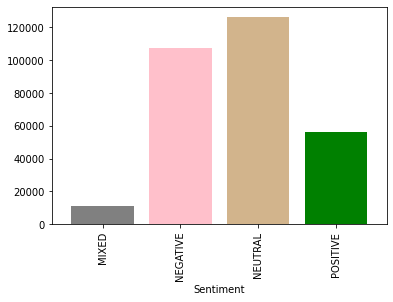

In [253]:
colors = ['Grey', 'Pink', 'Tan', 'Green']
sentiment_results.groupby('Sentiment').size().plot.bar(stacked=True, color = colors, width=0.8);

In [254]:
sentiment_results.groupby('Sentiment').size()/sentiment_results['Sentiment'].count()

Sentiment
MIXED       0.036960
NEGATIVE    0.356819
NEUTRAL     0.420070
POSITIVE    0.186151
dtype: float64

In [255]:
# sentiment_results.groupby('Sentiment').size()
sentiment_results['Sentiment'].count()
# sentiment_results.count()

300788

In [ ]:
# sentiment_results.urls.unique()

In [256]:
#Zoom in to individual Videos

# for url in sentiment_results.urls.unique():
#   print(url)

sentiment_results.groupby('Video ID').size().sort_values(ascending=False)

Video ID
ZfFe4RngT-w    63372
HxDXKB59JFg    63278
BtN-goy9VOY    57826
5DGwOJXSxqg    25223
fudTj7i4gJA     8731
LKT7fGL_Uh0     6595
k9wRPOeUhls     6349
DqSpzm2jsgw     5510
e8FCiP2IXWM     4664
T69-aH3s0vw     4522
BSQrskqqIKE     4453
fUcAhhqwGVw     4411
b7pAc7-vTvo     4331
MiqRBaEehIU     4306
DCdxsnRF1Fk     4224
A-1KmtpvM9M     3956
ZL1z3Uju-I0     3956
Ug9xQ7LQnsw     3769
w2KlawRXjGM     3543
1z_mBM3OWMM     3463
ewFkYdEv2w0     3298
s_3jKDRnF4c     3225
UdQri8yLXFA     2886
N4vfuuReV5c     1861
4yfPs6pUjQI     1539
ih4xVzLQP24     1497
dtype: int64

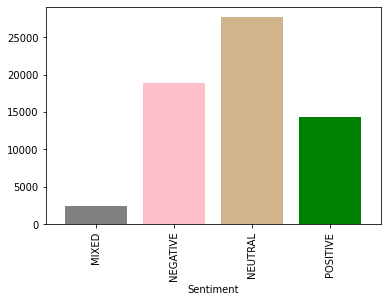

In [261]:
url = "ZfFe4RngT-w"

sentiment_results[sentiment_results['Video ID']==url].groupby('Sentiment').size().plot.bar(stacked=True, color = colors, width=0.8);

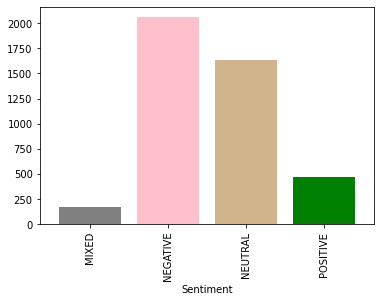

In [262]:
url = "b7pAc7-vTvo"

sentiment_results[sentiment_results['Video ID']==url].groupby('Sentiment').size().plot.bar(stacked=True, color = colors, width=0.8);

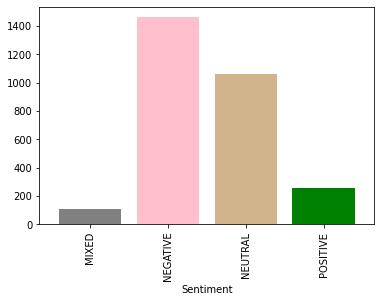

In [263]:
url = "UdQri8yLXFA"

sentiment_results[sentiment_results['Video ID']==url].groupby('Sentiment').size().plot.bar(stacked=True, color = colors, width=0.8);